In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import cvxpy as cp
import seaborn as sns
sns.set_style('whitegrid')

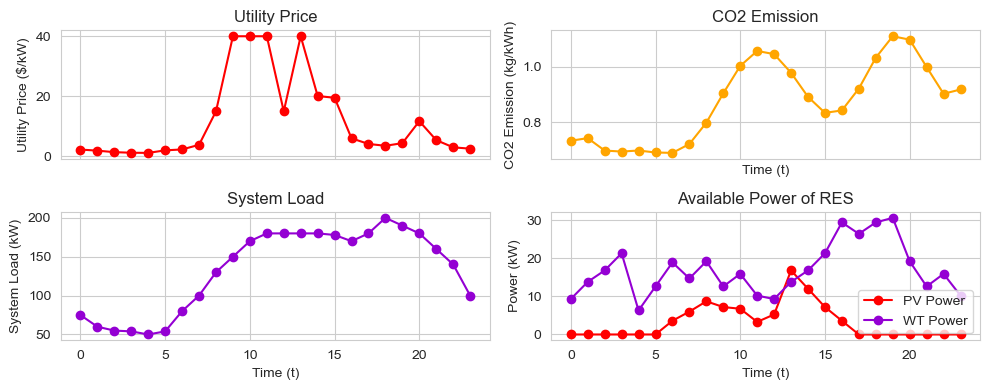

In [2]:
pv_data = np.load('./data/pv.npy')
wt_data = np.load('./data/wt.npy')
price_data = np.load('./data/price.npy')
load_data = np.load('./data/load.npy')
co2_data = np.load('./data/co2.npy')/1000

# Create the index array (1 to 24) for the horizontal axis
t = np.arange(0, 24)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 4), sharex=True)
axs = axs.flatten()

# Plot Price_utility
axs[0].plot(t, price_data, marker='o', linestyle='-', color='r')
axs[0].set_ylabel('Utility Price ($/kW)')
axs[0].set_title('Utility Price')
axs[0].grid(True)

# Plot CO2_emission
axs[1].plot(t, co2_data, marker='o', linestyle='-', color='orange')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('CO2 Emission (kg/kWh)')
axs[1].set_title('CO2 Emission')
axs[1].grid(True)

# Plot Power_load
axs[2].plot(t, load_data, marker='o', linestyle='-', color='darkviolet')
axs[2].set_xlabel('Time (t)')
axs[2].set_ylabel('System Load (kW)')
axs[2].set_title('System Load')
axs[2].grid(True)

# Plot PV/Wind
axs[3].plot(t, pv_data, marker='o', linestyle='-', color='r', label='PV Power')
axs[3].plot(t, wt_data, marker='o', linestyle='-', color='darkviolet', label='WT Power')
axs[3].set_xlabel('Time (t)')
axs[3].set_ylabel('Power (kW)')
axs[3].set_title('Available Power of RES')
axs[3].grid(True)
axs[3].legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


## 2d plot

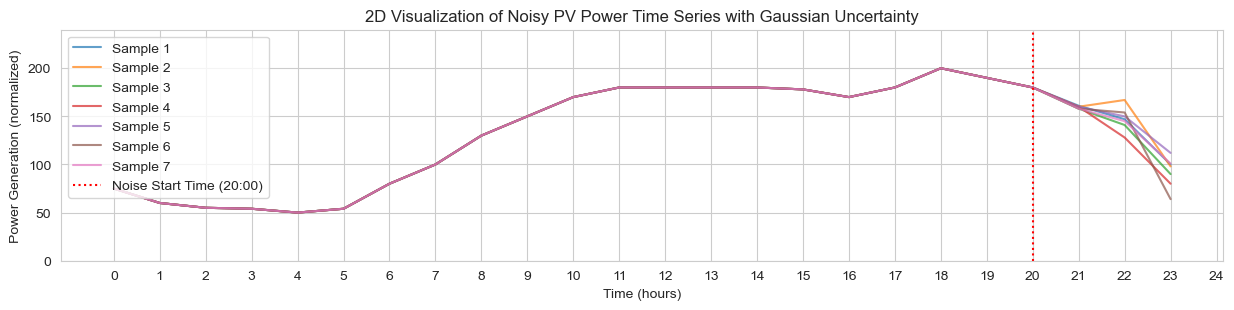

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate a Gaussian time series
def generate_pv_power(mean, std):
    time_steps = np.linspace(0, 24, 24 * 4)  # 15-minute resolution
    power = np.exp(-0.5 * ((time_steps - mean) / std)**2)  # Gaussian curve
    return time_steps, power

# Function to add Gaussian noise with varying intensity and proportional to power
def add_uncertainty(time_series, start_time, base_noise_std):
    time_steps = np.linspace(0, 24, len(time_series))
    noisy_series = time_series.copy()
    start_index = np.searchsorted(time_steps, start_time)+1
    total_horizon = len(time_series) - start_index

    # Define the Gaussian uncertainty function
    for i in range(start_index, len(time_series)):
        time_distance = (i - start_index) / total_horizon  # Normalize distance to [0, 1]
        # Gaussian function for uncertainty, centered at the midpoint of the horizon
        uncertainty_scale = np.exp(-0.5 * ((time_distance - 1) ** 2) / (0.5 ** 2))  # Narrow Gaussian
        noise_scale = base_noise_std * uncertainty_scale  # Scale noise by the Gaussian function
        noise = np.random.normal(0, noise_scale) * noisy_series[i]
        noisy_series[i] += noise

    noisy_series[start_index:] = np.clip(noisy_series[start_index:], 0, None)  # Ensure no negative power
    return noisy_series

# Function to plot multiple samples in 2D
def plot_2d_samples(time_steps, power_series, start_time, base_noise_std, num_samples=5):
    plt.figure(figsize=(15, 3))

    for i in range(num_samples):
        noisy_series = add_uncertainty(power_series, start_time, base_noise_std)
        plt.plot(time_steps, noisy_series, label=f'Sample {i+1}', alpha=0.7)

    # plt.plot(time_steps, power_series, label='Original PV Power', color='black', linewidth=2)
    plt.axvline(start_time, color='red', linestyle=':', label=f'Noise Start Time ({start_time}:00)')

    # Set x-axis ticks
    hours_ticks = np.arange(0, 25, 1)
    plt.xticks(hours_ticks, minor=False)


    plt.title("2D Visualization of Noisy PV Power Time Series with Gaussian Uncertainty")
    plt.xlabel("Time (hours)")
    plt.ylabel("Power Generation (normalized)")
    plt.legend()
    # plt.grid()
    plt.ylim([0, np.max(noisy_series)*1.2])
    plt.show()

    return noisy_series

# Main code
noisy_series = plot_2d_samples(t, load_data, start_time=20, base_noise_std=0.2, num_samples=7)


# CVPXY 

In [4]:
# Define the dictionary
DG_coeffs = {
    "MT": {
        "Pmin": 6,  # kW
        "Pmax": 30, # kW
        "b" : 4.37, # €/kWh
        "c": 85.06, # €/h
        "ef": 724.6/1000,# kg/kWh
        "Type": "Microturbine"
    },
    "FC": {
        "Pmin": 3,   # kW
        "Pmax": 30,  # kW
        "b": 2.84,   # €/kWh
        "c": 255.18, # €/h
        "ef": 489.4/1000, # kg/kWh
        "Type": "FC"
    },
    "WT": {
        "Pmin": 0,  # kW
        "Pmax": 15, # kW
        "b": 10.63, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Wind Turbine"
    },
    "PV1": {
        "Pmin": 0,  # kW
        "Pmax": 3,  # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 1"
    },
    "PV2": {
        "Pmin": 0 , # kW
        "Pmax": 10, # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 2"
    }
}

# Print the dictionary
pprint(DG_coeffs)


{'FC': {'Pmax': 30,
        'Pmin': 3,
        'Type': 'FC',
        'b': 2.84,
        'c': 255.18,
        'ef': 0.4894},
 'MT': {'Pmax': 30,
        'Pmin': 6,
        'Type': 'Microturbine',
        'b': 4.37,
        'c': 85.06,
        'ef': 0.7246},
 'PV1': {'Pmax': 3,
         'Pmin': 0,
         'Type': 'Photovoltaic 1',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'PV2': {'Pmax': 10,
         'Pmin': 0,
         'Type': 'Photovoltaic 2',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'WT': {'Pmax': 15,
        'Pmin': 0,
        'Type': 'Wind Turbine',
        'b': 10.63,
        'c': 0,
        'ef': 0}}


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 02 06:33:37 PM: Your problem has 120 variables, 288 constraints, and 0 parameters.
(CVXPY) Jan 02 06:33:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 02 06:33:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 02 06:33:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 02 06:33:37 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 02 06:33:37 PM: Compiling problem (target solver=SCIP).
(

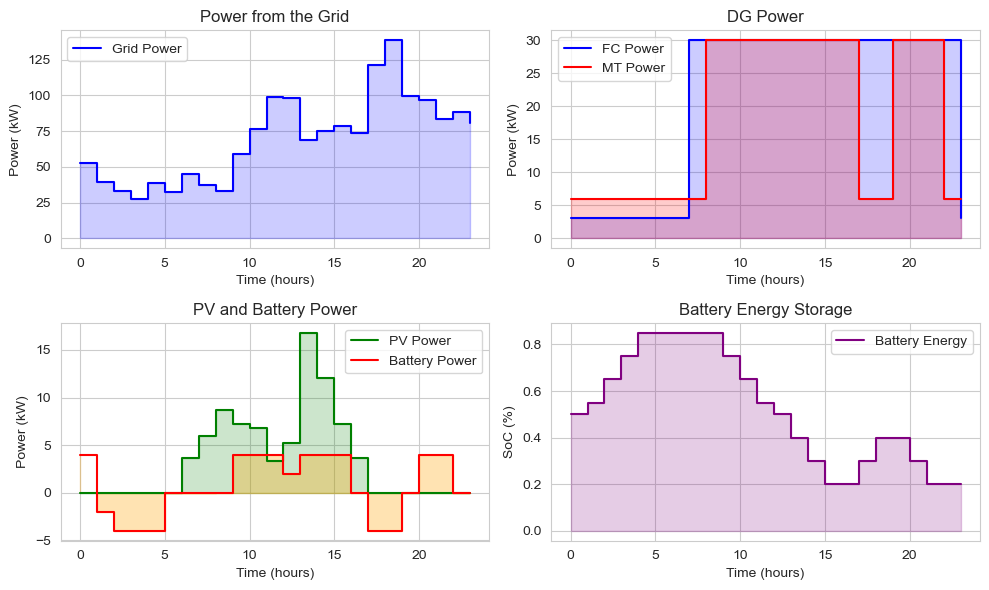

In [5]:

def solve_opt(pv_data_i, wt_data_i):
    # Parameters
    num_time_steps = 24
    time_resolution = 1

    # Storage constraints
    storage_capacity = 40  # Example capacity
    capacity_high_limit = 0.85
    capacity_low_limit = 0.2

    PGmax = 200
    PBmax = 4

    # Decision Variables
    p_grid = cp.Variable(num_time_steps)
    p_FC = cp.Variable(num_time_steps)
    p_MT = cp.Variable(num_time_steps)
    p_storage = cp.Variable(num_time_steps)
    storage_energy = cp.Variable(num_time_steps, nonneg=True)

    # Constraints
    constraints = []

    # Power balance constraints
    constraints.append(2*pv_data_i + wt_data_i + p_grid + p_FC + p_MT + p_storage == load_data)

    # Grid constraints
    constraints.append(p_grid <= PGmax)
    constraints.append(p_grid >= -PGmax)

    # DG constraints
    constraints.append(p_FC <= DG_coeffs['FC']['Pmax'])
    constraints.append(p_FC >= DG_coeffs['FC']['Pmin'])
    constraints.append(p_MT <= DG_coeffs['MT']['Pmax'])
    constraints.append(p_MT >= DG_coeffs['MT']['Pmin'])

    # Storage constraints
    constraints.append(storage_energy <= storage_capacity * capacity_high_limit)
    constraints.append(storage_energy >= storage_capacity * capacity_low_limit)
    constraints.append(p_storage <= PBmax)
    constraints.append(p_storage >= -PBmax)
    constraints.append(storage_energy[0] == storage_capacity / 2)  # Initial storage level
    # constraints.append(storage_energy[-1] == storage_capacity / 2)

    constraints.append(storage_energy[1:] == storage_energy[:-1] - p_storage[1:] * time_resolution)

    # # Smoothing constraint to avoid abrupt changes
    # smoothing_penalty = cp.tv(p_grid_positive) + cp.tv(p_grid_negative) + cp.tv(p_storage) + cp.tv(p_chargers) 

    # Objective: Minimize total grid power usage, slack, and smoothing
    objective = cp.Minimize(
        cp.sum(cp.multiply(price_data, p_grid) + 0.01*cp.multiply(co2_data, p_grid)) + 
        cp.sum(DG_coeffs['FC']['c'] + cp.multiply(DG_coeffs['FC']['b'], p_FC) + 0.01*cp.multiply(DG_coeffs['FC']['ef'], p_FC)) + 
        cp.sum(DG_coeffs['MT']['c'] + cp.multiply(DG_coeffs['MT']['b'], p_MT) + 0.01*cp.multiply(DG_coeffs['MT']['ef'], p_MT))
    )

    # Problem definition and solving
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCIP, verbose=True)

    # Output the results
    print("Problem status:", problem.status)
    if problem.status not in ["infeasible", "unbounded"]:
        print("Optimal objective value:", objective.value)
    else:
        print("The problem is infeasible or unbounded.")

    plt.figure(figsize=(10, 6))
    time_steps = np.arange(len(p_grid.value))

    # Plot grid power
    plt.subplot(2, 2, 1)
    plt.plot(time_steps, p_grid.value, label='Grid Power', color='blue', drawstyle='steps-post')
    plt.fill_between(time_steps, 0, p_grid.value, color='blue', alpha=0.2, step="post")
    plt.xlabel('Time (hours)')
    plt.ylabel('Power (kW)')
    plt.title('Power from the Grid')
    plt.legend()

    # Plot DG power
    plt.subplot(2, 2, 2)
    plt.plot(time_steps, p_FC.value, label='FC Power', color='blue', drawstyle='steps-post')
    plt.fill_between(time_steps, 0, p_FC.value, color='blue', alpha=0.2, step="post")

    plt.plot(time_steps, p_MT.value, label='MT Power', color='red', drawstyle='steps-post')
    plt.fill_between(time_steps, 0, p_MT.value, color='red', alpha=0.2, step="post")
    plt.xlabel('Time (hours)')
    plt.ylabel('Power (kW)')
    plt.title('DG Power')
    plt.legend()

    # Plot PV power and battery power
    plt.subplot(2, 2, 3)
    plt.plot(time_steps, pv_data_i, label='PV Power', color='green', drawstyle='steps-post')
    plt.fill_between(time_steps, 0, pv_data_i, color='green', alpha=0.2, step="post")
    plt.plot(time_steps, p_storage.value, label='Battery Power', color='red', drawstyle='steps-post')
    plt.fill_between(time_steps, 0, p_storage.value, where=np.array(p_storage.value) >= 0, color='orange', alpha=0.3, step="post")
    plt.fill_between(time_steps, 0, p_storage.value, where=np.array(p_storage.value) <= 0, color='orange', alpha=0.3, step="post")
    plt.xlabel('Time (hours)')
    plt.ylabel('Power (kW)')
    plt.title('PV and Battery Power')
    plt.legend()

    # Plot battery energy
    plt.subplot(2, 2, 4)
    plt.plot(time_steps, np.array(storage_energy.value) / storage_capacity, label='Battery Energy', color='purple', drawstyle='steps-post')
    plt.fill_between(time_steps, 0, np.array(storage_energy.value) / storage_capacity, color='purple', alpha=0.2, step="post")
    plt.xlabel('Time (hours)')
    plt.ylabel('SoC (%)')
    plt.title('Battery Energy Storage')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return p_grid.value, p_FC.value, p_MT.value, p_storage.value, storage_energy.value


p_grid, p_FC, p_MT, p_storage, storage_energy = solve_opt(pv_data, wt_data)

In [6]:
p_storage

array([ 4., -2., -4., -4., -4.,  0.,  0.,  0.,  0.,  4.,  4.,  4.,  2.,
        4.,  4.,  4.,  0., -4., -4.,  0.,  4.,  4.,  0.,  0.])

# Optimization with noise

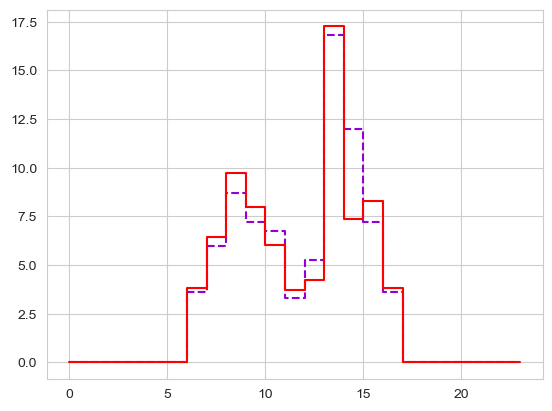

In [7]:
noisy_series.shape
plt.plot(t, pv_data, linestyle='--', color='darkviolet', label='PV Power', drawstyle='steps-post')
plt.plot(t, noisy_series, linestyle='-', color='r', label='noisy PV Power', drawstyle='steps-post')

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 02 06:33:40 PM: Your problem has 120 variables, 288 constraints, and 0 parameters.
(CVXPY) Jan 02 06:33:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 02 06:33:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 02 06:33:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 02 06:33:40 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 02 06:33:40 PM: Compiling problem (target solver=SCIP).
(

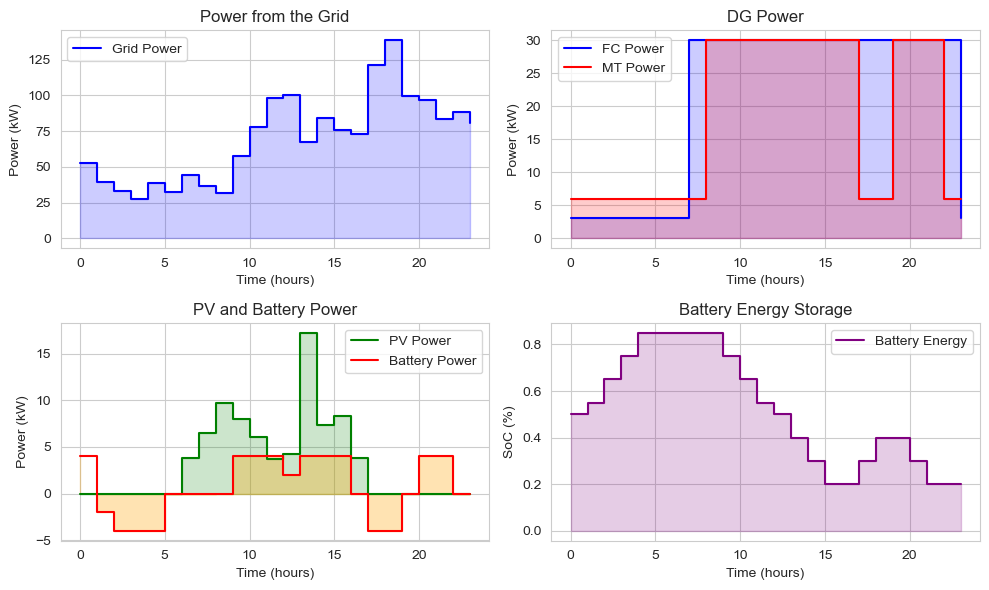

In [8]:
p_grid_n, p_FC_n, p_MT_n, p_storage_n, storage_energy_n = solve_opt(noisy_series, wt_data)

# compare desisions

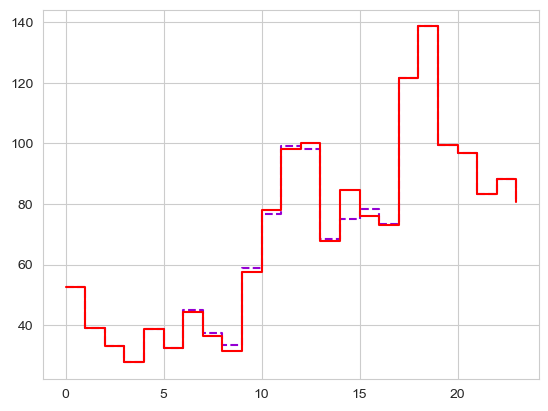

In [9]:
plt.plot(t, p_grid, linestyle='--', color='darkviolet', label='Grid Power', drawstyle='steps-post')
plt.plot(t, p_grid_n, linestyle='-', color='r', label='Noisy Grid Power', drawstyle='steps-post')   

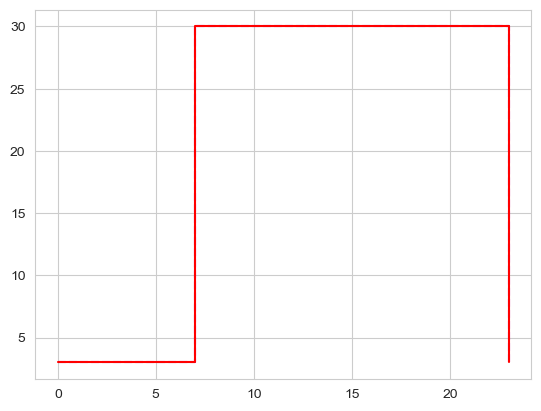

In [10]:
plt.plot(t, p_FC, linestyle='--', color='darkviolet', label='FC Power', drawstyle='steps-post')
plt.plot(t, p_FC_n, linestyle='-', color='r', label='Noisy FC Power', drawstyle='steps-post')

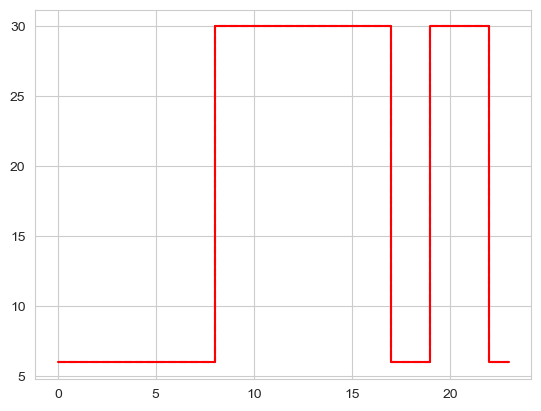

In [11]:
plt.plot(t, p_MT, linestyle='--', color='darkviolet', label='MT Power', drawstyle='steps-post')
plt.plot(t, p_MT_n, linestyle='-', color='r', label='Noisy MT Power', drawstyle='steps-post')

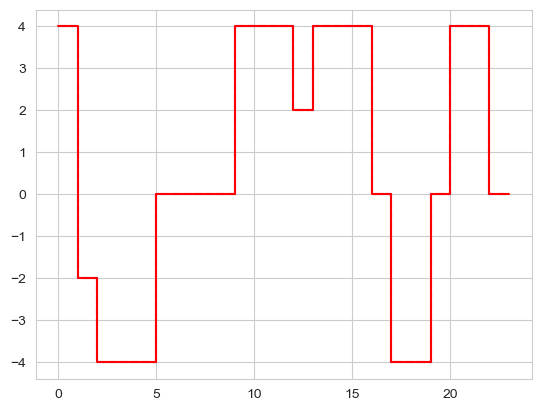

In [12]:
plt.plot(t, p_storage, linestyle='--', color='darkviolet', label='Battery Power', drawstyle='steps-post')
plt.plot(t, p_storage_n, linestyle='-', color='r', label='Noisy Battery Power', drawstyle='steps-post')

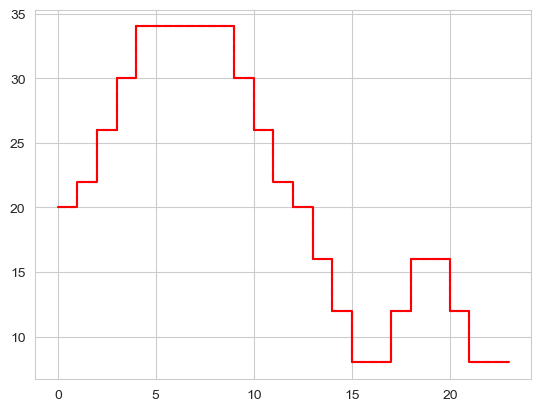

In [13]:
plt.plot(t, storage_energy, linestyle='--', color='darkviolet', label='Battery Energy', drawstyle='steps-post')
plt.plot(t, storage_energy_n, linestyle='-', color='r', label='Noisy Battery Energy', drawstyle='steps-post')

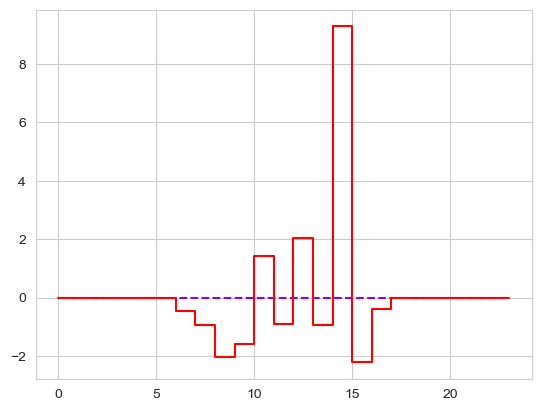

In [14]:
# plot power balance problem

balanced = load_data - (2*pv_data + wt_data + p_grid + p_FC + p_MT + p_storage)
unbalaced = load_data - (2*noisy_series + wt_data + p_grid + p_FC + p_MT + p_storage)
plt.plot(t, balanced, linestyle='--', color='darkviolet', label='Balanced Power', drawstyle='steps-post')
plt.plot(t, unbalaced, linestyle='-', color='r', label='Unbalanced Power', drawstyle='steps-post')